In [89]:
import ollama

model = 'gemma3:4b-it-qat'

with open("system_promptv2.txt", "r") as file:
    system_prompt = file.read()

In [90]:
def remove_extras(text):
    return text.strip().replace("\n", "").replace("```", '').replace('json','')

In [91]:
response = ollama.chat(model=model, messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": "John's eating food. It is daytime. He sits on the chair."}
])
print(f'actual response: {response['message']['content']}')
remove_extras(response['message']['content'])

actual response: [
{"head_entity":{"entity":"John","attribute":""},"relation":{"relation":"eating","attribute":""},"tail_entity":{"entity":"food","attribute":""}},
{"head_entity":{"entity":"John","attribute":""},"relation":{"relation":"sits_on","attribute":""},"tail_entity":{"entity":"chair","attribute":""}},
{"head_entity":{"entity":"John","attribute":""},"relation":{"relation":"is_daytime","attribute":""},"tail_entity":{"entity":"daytime","attribute":""}}
]


'[{"head_entity":{"entity":"John","attribute":""},"relation":{"relation":"eating","attribute":""},"tail_entity":{"entity":"food","attribute":""}},{"head_entity":{"entity":"John","attribute":""},"relation":{"relation":"sits_on","attribute":""},"tail_entity":{"entity":"chair","attribute":""}},{"head_entity":{"entity":"John","attribute":""},"relation":{"relation":"is_daytime","attribute":""},"tail_entity":{"entity":"daytime","attribute":""}}]'

In [92]:
import pdfplumber

full_content = ""
start_page = 8
with pdfplumber.open("data.pdf") as pdf:
    for i, page in enumerate(pdf.pages[start_page:], start=start_page):
        text = page.extract_text()
        if text:
            full_content += text + "\n"

print(f'total chars: {len(full_content)}')

total chars: 706746


In [ ]:
import json

def process_chunk(text, out):
    response = ollama.chat(model=model, messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": text}
        ])
    
    resp_content = remove_extras(response['message']['content'])
    try:
        t = json.loads(resp_content)
        out.extend(t)
    except json.JSONDecodeError:
        print(f"Failed to decode JSON from response: {resp_content}")
    return response

In [94]:
import pickle

def save_obj(data, filename):
    with open(filename, "wb") as f:
        pickle.dump(data, f)

In [95]:
from tqdm.notebook import trange

all_triplets = []

sentences = full_content.split('.')
batch_size = 10
for i in trange(0, len(sentences), batch_size):
    batch = sentences[i:i+batch_size]
    paragraph = ".".join(batch)
    process_chunk(paragraph, all_triplets)
    if i % 100:
        save_obj(all_triplets, "all_triplets.pkl")

len(all_triplets)
print(all_triplets[:20])
save_obj(all_triplets, "all_triplets.pkl")

  0%|          | 0/728 [00:00<?, ?it/s]

Failed to decode JSON from response: [{"head_entity":{"entity":"HTML document","attribute":""},"relation":{"relation":"has_structure","attribute":""}},{"head_entity":{"entity":"HTML document","attribute":""},"relation":{"relation":"has_elements","attribute":""},"tail_entity":{"entity":"HTML5 elements","attribute":""}},{"head_entity":{"entity":"HTML5 elements","attribute":""},"relation":{"relation":"include","attribute":""},"tail_entity":{"entity":"<video> element","attribute":""}},{"head_entity":{"entity":"HTML5 elements","attribute":""},"relation":{"relation":"include","attribute":""},"tail_entity":{"entity":"<audio> element","attribute":""}},{"head_entity":{"entity":"HTML5 elements","attribute":""},"relation":{"relation":"include","attribute":""},"tail_entity":{"entity":"<datalist> element","attribute":""}},{"head_entity":{"entity":"HTML5 elements","attribute":""},"relation":{"relation":"include","attribute":""},"tail_entity":{"entity":"<output> element","attribute":""}},{"head_entit

In [103]:
import networkx as nx
from typing import Dict, Any, Iterable, Optional

def _get_entity(d: Any) -> tuple[str, str]:
    """Accepts {'entity':..., 'attribute':...} or a plain string; returns (entity, attribute)."""
    if isinstance(d, dict):
        return (str(d.get("entity", "") or "").strip(),
                str(d.get("attribute", "") or "").strip())
    if isinstance(d, str):
        return d.strip(), ""
    return "", ""

def _get_relation(d: Any) -> tuple[str, str]:
    """Accepts {'relation':..., 'attribute':...} or a plain string; returns (relation, attribute)."""
    if isinstance(d, dict):
        return (str(d.get("relation", "") or "").strip(),
                str(d.get("attribute", "") or "").strip())
    if isinstance(d, str):
        return d.strip(), ""
    return "", ""

def _normalize_relation(r: str) -> str:
    # minimal normalization; extend as needed
    rlow = r.lower().strip()
    mapping = {
        "is_part_of": "part_of", "is a": "type_of", "is an": "type_of",
        "is_a": "type_of", "focuses on": "focus_on", "focuses_on": "focus_on",
        "contributes to": "contribute_to", "contributes_to": "contribute_to",
        "uses": "use", "interact with": "interact_with",
    }
    return mapping.get(rlow, rlow.replace(" ", "_"))

def _salvage_tail_if_missing(head: str, rel: str, r_attr: str, tail: str, t_attr: str) -> tuple[str, str, str]:
    """
    If tail is empty but relation.attribute contains a plausible noun phrase,
    move it to tail.entity (and clear relation.attribute). Return (tail, r_attr, t_attr).
    """
    if tail:
        return tail, r_attr, t_attr
    # Heuristic: if relation.attribute looks like content (“intuitive interface”, “conversion rates”), use it as tail.
    if r_attr and len(r_attr.split()) >= 1:
        return r_attr, "", t_attr  # move attr -> tail.entity
    return tail, r_attr, t_attr

def sanitize_triple(t: Dict[str, Any]) -> Optional[Dict[str, Dict[str, str]]]:
    """Return a well-formed triple or None (skip)."""
    if not isinstance(t, dict):
        return None

    head,  h_attr = _get_entity(t.get("head_entity"))
    rel,   r_attr = _get_relation(t.get("relation"))
    tail,  t_attr = _get_entity(t.get("tail_entity"))

    # salvage some common LLM mistakes (tail missing but relation.attribute carries the complement)
    tail, r_attr, t_attr = _salvage_tail_if_missing(head, rel, r_attr, tail, t_attr)

    # minimal validity check
    if not head or not rel or not tail:
        return None

    rel_norm = _normalize_relation(rel)

    return {
        "head_entity": {"entity": head, "attribute": h_attr},
        "relation":    {"relation": rel_norm, "attribute": r_attr},
        "tail_entity": {"entity": tail, "attribute": t_attr},
    }

def iter_sanitized(triples: Iterable[Dict[str, Any]]):
    """Yield only valid, sanitized triples; log skips."""
    for i, t in enumerate(triples):
        st = sanitize_triple(t)
        if st is None:
            print(f"[skip #{i}] incomplete or malformed triple: {t}")
            continue
        yield st

In [ ]:
def build_graph(triples: Iterable[Dict[str, Any]]) -> nx.DiGraph:
    G = nx.DiGraph()
    for tr in iter_sanitized(triples):
        head = tr["head_entity"]["entity"]
        tail = tr["tail_entity"]["entity"]
        rel  = tr["relation"]["relation"]

        # add nodes with optional attributes
        G.add_node(head, attr=tr["head_entity"]["attribute"])
        G.add_node(tail, attr=tr["tail_entity"]["attribute"])

        # add edge with relation + relation attribute
        G.add_edge(head, tail, relation=rel, attribute=tr["relation"]["attribute"])
    return G

G = build_graph(all_triplets)

[skip #10] incomplete or malformed triple: {'head_entity': {'entity': 'Front-end development', 'attribute': ''}, 'relation': {'relation': 'is', 'attribute': ''}}
[skip #134] incomplete or malformed triple: {'head_entity': {'entity': 'web accessibility', 'attribute': ''}, 'relation': {'relation': 'was a crucial consideration', 'attribute': ''}}
[skip #190] incomplete or malformed triple: {'head_entity': {'entity': 'copy', 'attribute': ''}, 'relation': {'relation': 'guide', 'attribute': ''}}
[skip #468] incomplete or malformed triple: {'head_entity': {'entity': 'navigation elements', 'attribute': ''}, 'relation': {'relation': 'summary', 'attribute': ''}}
[skip #469] incomplete or malformed triple: {'head_entity': {'entity': 'CSS styling', 'attribute': ''}, 'relation': {'relation': 'simplified', 'attribute': ''}}
[skip #470] incomplete or malformed triple: {'head_entity': {'entity': 'JavaScript scripting', 'attribute': ''}, 'relation': {'relation': 'simplified', 'attribute': ''}}
[skip #5

graph_metam_kafka.html


{('Front-end development',
  'practice'): Text(0.4157033473013929, 0.2321447292081864, 'is'),
 ('Front-end development',
  'HTML'): Text(0.05869098532063122, 0.06389688326583198, 'uses'),
 ('Front-end development',
  'CSS'): Text(0.027709001313163784, -0.018537398529065552, 'uses'),
 ('Front-end development',
  'JavaScript'): Text(0.06236837537635287, -9.234356536191868e-05, 'use'),
 ('Front-end development',
  'visual interface'): Text(-0.3446971617768495, 0.42296179493912756, 'provides'),
 ('Front-end development',
  'part'): Text(0.3845951056470922, -0.2659500645146977, 'is'),
 ('Front-end development',
  'user interactions'): Text(-0.3469134111876033, -0.29921644505488554, 'focuses_on'),
 ('Front-end development',
  'skill'): Text(-0.4398543902463474, 0.05793303539058514, 'is'),
 ('Front-end development',
  'digital world'): Text(-0.1304309814512934, -0.39125354647456323, 'is_important'),
 ('Front-end development',
  'null'): Text(0.1261512950539072, -0.42302608090586413, 'is'),
 (

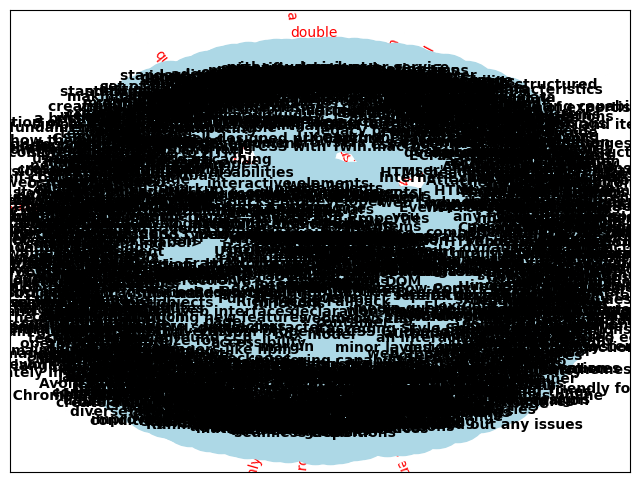

In [106]:
from pyvis.network import Network
import networkx as nx

# G = nx.karate_club_graph()  # example graph

net = Network(notebook=True, cdn_resources='in_line')
net.from_nx(G)
net.show("graph_metam_kafka.html")

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # layout for visualization

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue")
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Draw edge labels (relations)
edge_labels = {(u, v): d['relation'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

In [168]:
import pickle
import json
import networkx as nx
from itertools import combinations
import ollama
from typing import Iterable, Dict, Any

queries = ['What is CSS used for? ', 'How to engage with online communities?', 'What tools are used for frontend?', 'How to setup my environment?']

all_triplets = pickle.load(open("all_triplets.pkl", "rb"))

In [169]:
def iter_sanitized(triples):
    """Iterator that yields sanitized triples - add your sanitization logic here if needed"""
    for triple in triples:
        yield triple

def build_graph(triples: Iterable[Dict[str, Any]]) -> nx.DiGraph:
    G = nx.DiGraph()
    for tr in iter_sanitized(triples):
        head = tr["head_entity"]["entity"]
        tail = tr["tail_entity"]["entity"]
        rel  = tr["relation"]["relation"]

        # add nodes with optional attributes
        G.add_node(head, attr=tr["head_entity"]["attribute"])
        G.add_node(tail, attr=tr["tail_entity"]["attribute"])

        # add edge with relation + relation attribute
        G.add_edge(head, tail, relation=rel, attribute=tr["relation"]["attribute"])
    return G

def build_graph_flexible(triples) -> nx.DiGraph:
    G = nx.DiGraph()
    
    for tr in triples:
        try:
            if isinstance(tr, dict):
                head = None
                tail = None
                rel = None
                
                # Try to extract head entity
                if "head_entity" in tr:
                    head = tr["head_entity"]["entity"]
                elif "head" in tr:
                    head = tr["head"]
                
                # Try to extract tail entity (might not exist)
                if "tail_entity" in tr:
                    tail = tr["tail_entity"]["entity"]
                elif "tail" in tr:
                    tail = tr["tail"]
                
                # Try to extract relation
                if "relation" in tr:
                    if isinstance(tr["relation"], dict):
                        rel = tr["relation"]["relation"]
                    else:
                        rel = tr["relation"]
                
                # Only add edge if we have at least head and relation
                if head is not None and rel is not None:
                    if tail is not None:
                        # Add edge between head and tail
                        G.add_edge(head, tail, relation=rel, label=rel)
                    else:
                        # If no tail, just add the head node with relation as attribute
                        G.add_node(head, relation=rel)
                        
        except Exception as e:
            print(f"Error processing triplet {tr}: {e}")
            continue
    
    return G

# Create the graph using the flexible function
G = build_graph_flexible(all_triplets)
print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph created with 4427 nodes and 4778 edges


In [170]:
system_prompt_root_word = """You are a helpful assistant that extracts the root form of the given word in lowercase.
Return only the root word in response."""

system_prompt_key_words = """You are a helpful assistant, expert of English language who can extracts keyword from the given question in root form (e.g. ran becomes run) and lowercase.
The returned keywords should be critical to answer the question.
Categorize the keywords into entity and relation keywords.
keywords must be in root form and lowercase.
The response should be in following format, no additional text:
{"entity": [list of entity keywords], "relation": [list of relation keywords]}"""

def get_llm_response(text, system_prompt):
    response = ollama.chat(model="gemma3:4b-it-qat", messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": text}
    ])
    return response['message']['content']

In [ ]:
def get_nodes(G, node):
    needle = ("" if node is None else str(node)).lower()
    return list({
        n for n in G.nodes
        if isinstance(n, str) and needle in n.lower()
    })

def _assert_is_graph(G):
    if not isinstance(G, (nx.Graph, nx.DiGraph, nx.MultiGraph, nx.MultiDiGraph)):
        raise TypeError(f"G is not a NetworkX graph, got {type(G)}")

def _edge_relations(G, u, v):
    data = G[u][v]
    if isinstance(G, (nx.MultiGraph, nx.MultiDiGraph)):
        rels = []
        for _, attrs in data.items():                # edge_key -> attrs
            rel = attrs.get("relation") or attrs.get("label")
            if rel is not None:
                rels.append(str(rel))
        return rels
    else:
        rel = data.get("relation") or data.get("label")
        return [str(rel)] if rel is not None else []

def search_kg2(G, query, path_cutoff=3):
    _assert_is_graph(G)

    # 1) Extract keywords with the LLM
    response = get_llm_response(query, system_prompt_key_words)
    try:
        keyword_resp = json.loads(response)
    except json.JSONDecodeError:
        # If malformed JSON, return empty result
        return []

    # 2) Normalize inputs
    entity_keywords   = [str(e).strip() for e in keyword_resp.get('entity', []) if str(e).strip()]
    relation_keywords = [str(r).strip().lower() for r in keyword_resp.get('relation', []) if str(r).strip()]

    # 3) Build pairs; early exit if <2 entities
    entities = entity_keywords
    pairs = list(combinations(entities, 2))
    relations = []

    # 4) Path search between each candidate source/target (both directions)
    for u_text, v_text in pairs:
        src_candidates = get_nodes(G, u_text)
        tgt_candidates = get_nodes(G, v_text)

        for S, T in ((src_candidates, tgt_candidates), (tgt_candidates, src_candidates)):
            for s in S:
                for t in T:
                    if s == t:
                        continue
                    try:
                        for path in nx.all_simple_paths(G, source=s, target=t, cutoff=path_cutoff):
                            for i in range(len(path) - 1):
                                u, v = path[i], path[i+1]
                                for rel in _edge_relations(G, u, v):
                                    if rel is not None:
                                        relations.append((u, rel, v))
                    except (nx.NodeNotFound, nx.NetworkXNoPath):
                        pass

    # 5) Relation-keyword lookup
    _assert_is_graph(G)
    if relation_keywords:
        rel_kw = set(relation_keywords)
        for u, v, attrs in G.edges(data=True):
            rel_val = str(attrs.get("relation") or attrs.get("label") or "").lower()
            if rel_val in rel_kw:
                relations.append((u, attrs.get("relation") or attrs.get("label"), v))


    relations = list({(str(a), str(b), str(c)) for (a, b, c) in relations})
    return relations


In [ ]:
# Process queries
for query in queries:
    try:
        triples = search_kg2(G, query)
        print(f'Number of relevant triples found: {len(triples)}')

        # --- Step 3: Send to model ---
        context = f"""
        You are given facts from a knowledge graph:

        {triples}

        Answer the user query based ONLY on these facts.
        Answer in full sentence.
        Query: {query}
        """

        response = ollama.chat(model="gemma3:4b-it-qat", messages=[{"role": "user", "content": context}])

        print('---'*20)
        print(f'Query: {query}\nAnswer: {response["message"]["content"]}')
        print('---'*20)
    except Exception as e:
        print(f'Error processing query "{query}": {e}')
        import traceback
        traceback.print_exc()

Number of relevant triples found: 7
------------------------------------------------------------
Query: What is CSS used for? 
Answer: Cascading Style Sheets is used for describing the presentation.
------------------------------------------------------------
Number of relevant triples found: 54
------------------------------------------------------------
Query: How to engage with online communities?
Answer: Online communities provide networking and allow users to share insights and participate in updates.
------------------------------------------------------------
Number of relevant triples found: 189
------------------------------------------------------------
Query: What tools are used for frontend?
Answer: Frontend development uses tools like JavaScript, HTML, CSS, and frameworks like Angular, React, and Vue.js.

------------------------------------------------------------
Number of relevant triples found: 2
------------------------------------------------------------
Query: How t